In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
import statsmodels

In [2]:
df = pd.read_excel("System_combined.xlsx")
df.set_index("DateTime", inplace=True)
df.sort_index(ascending=True)
df = df.drop("Unnamed: 0", axis = 1)
df['systemPrice'].interpolate(method='time', inplace=True)
df.isna().sum()


systemPrice    0
dtype: int64

## Tests for stationarity 

In [3]:
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print('Results of Augmented Dickey-Fuller Test:')
    adf_result = adfuller(timeseries)
    
    # Retrieve the p-value
    adf_pvalue = adf_result[1]
    
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_pvalue}')
    
    if adf_pvalue < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    print('\nResults of KPSS Test:')
    statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    
    # As the p-value is approximate, it should not be taken as an absolute measure of stationarity.
    if p_value < 0.05:
        print("The series is non-stationary.")
    else:
        print("The series is stationary.")



In [4]:

adf_test(df["systemPrice"]) #h0 can be rejected, there is  enough evidence that the timeseries is stationary
kpss_test(df["systemPrice"]) #h0 can be rejected, there is enough evidence that the timeseries is non-statinoary

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -9.577550489049926
p-value: 2.2025769433108786e-16
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 8.876045258727991
p-value: 0.01
The series is non-stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_57016\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [7]:

df["systemPricead"] = df["systemPrice"] + 30
df["systemPricelog"] = np.log(df["systemPricead"])
df = df["2023-01-01":"2023-12-31"]



# Finding Parameters for ARIMA

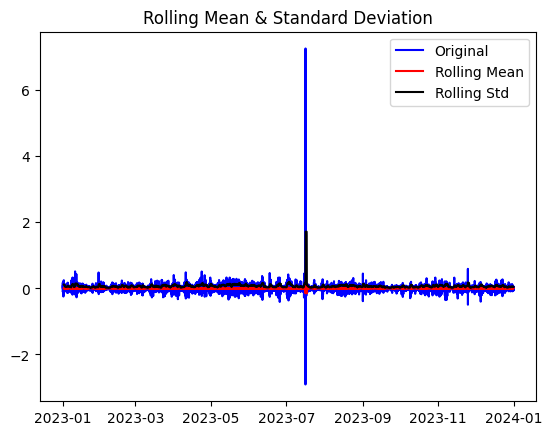

In [8]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

test_stationarity(df["systemPricelog"].diff().diff())
#adf_test(differenced_data)

In [12]:
import pandas as pd
from scipy import stats

# Assuming `df` is your DataFrame and it contains a column named 'value'
# which stores the time series data.

# Calculate the z-scores
df['z_score'] = stats.zscore(df['systemPricelog'])

# Filter out the outliers
threshold = 3
df_filtered = df[(df['z_score'] > -threshold) & (df['z_score'] < threshold)]

# Now df_filtered contains the original data without outliers.


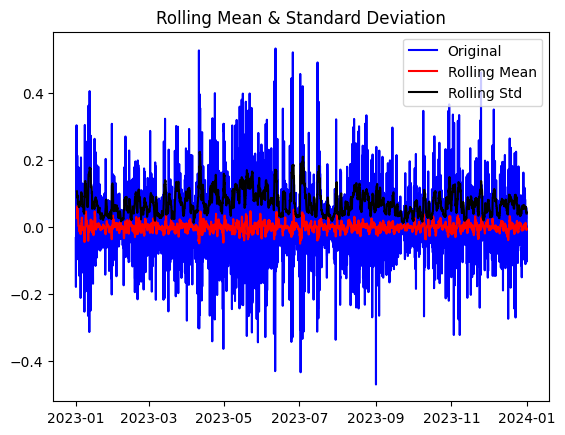

In [24]:
test_stationarity(df_filtered["systemPricelog"].diff().dropna())

In [20]:
adf_test(df_filtered["systemPricelog"].diff().dropna())
kpss_test(df_filtered["systemPricelog"].diff().dropna())

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -18.335945933379826
p-value: 2.2509838808301472e-30
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.0390993276488459
p-value: 0.1
The series is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_57016\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


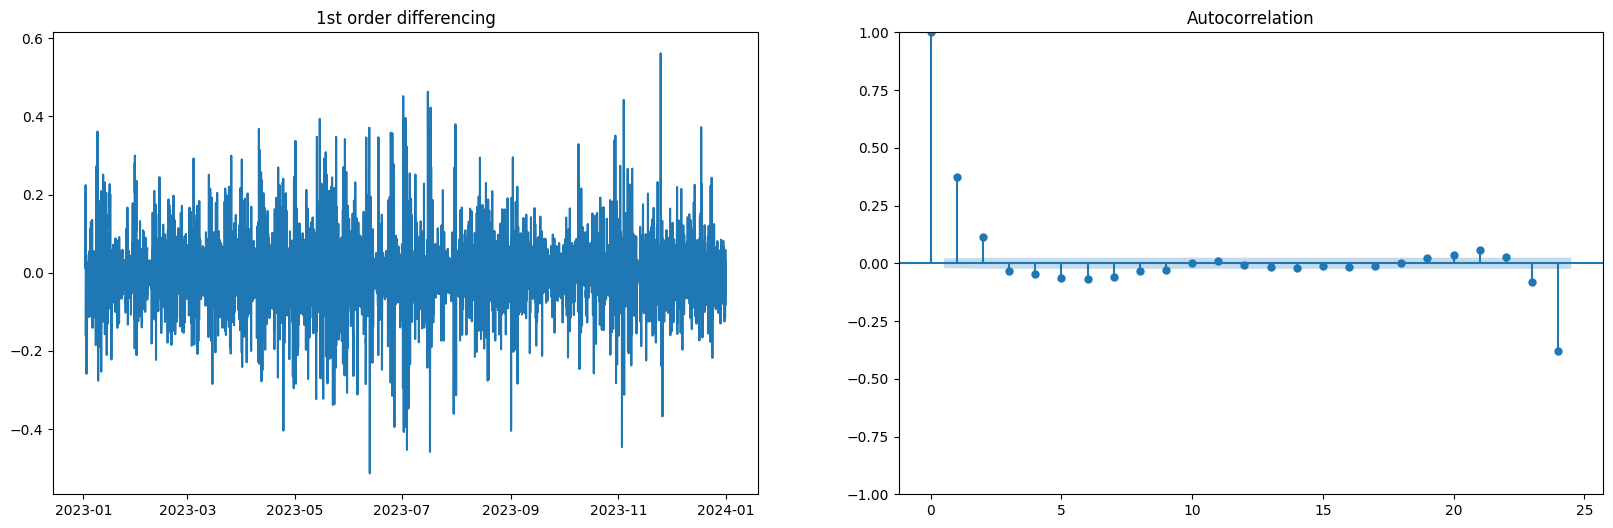

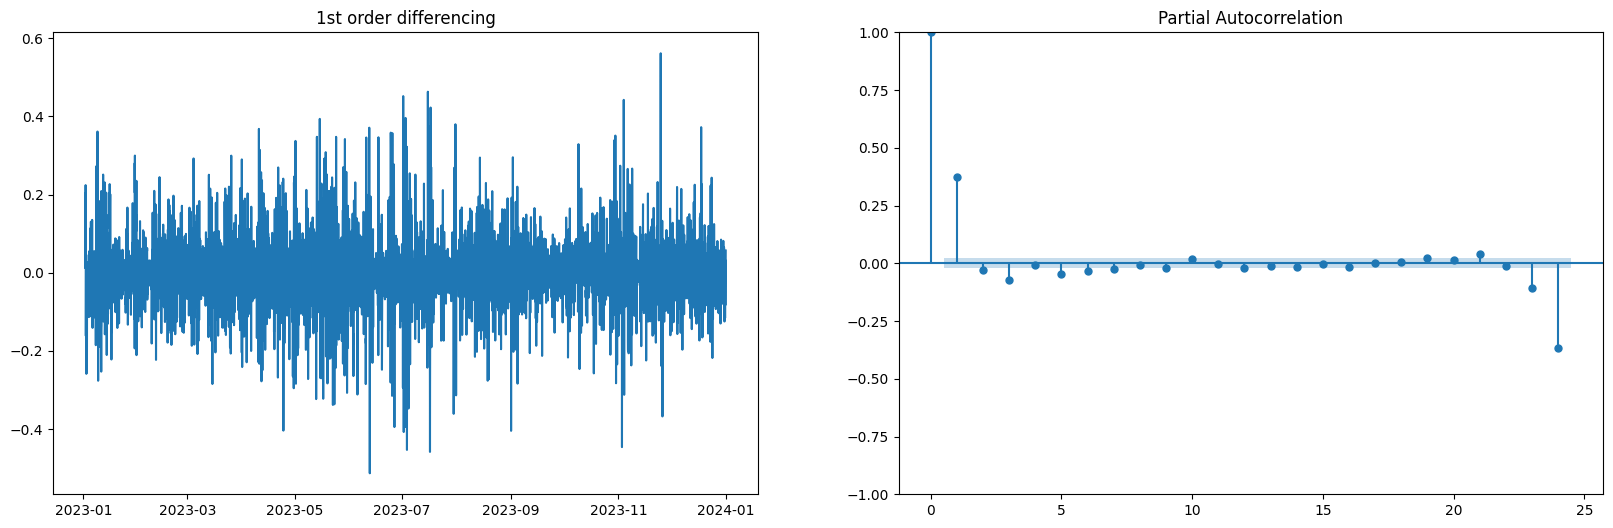

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -24.192702523374106
p-value: 0.0
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.0030741171361869215
p-value: 0.1
The series is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_57016\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [40]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#filtered_df = df["2018-01-01":"2019-12-31"]
# Assuming df["systemPrice"] is your data series.
differenced_data = df_filtered["systemPricelog"].diff().diff(24).dropna()


# Set a wider figure size. For example, (20, 6) makes the figure 20 inches wide and 6 inches tall.
f = plt.figure(figsize=(20, 6))

# First subplot for the differenced data.
ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(differenced_data)

# Second subplot for the ACF plot.
ax2 = f.add_subplot(122)
plot_acf(differenced_data, lags=24, ax=ax2)
plt.show()

# Create another figure for the PACF plot, with the same figsize to keep consistency.
f = plt.figure(figsize=(20, 6))

ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(differenced_data)

ax2 = f.add_subplot(122)
plot_pacf(differenced_data, lags=24, ax=ax2)
plt.show()

adf_test(differenced_data)
kpss_test(differenced_data)



## Trying to use the diff df and extracting seasonal component and trend being left with residuals

In [ ]:
# Re-importing the necessary libraries as the execution state was reset.
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

filtered_df = df["2023-01-01":"2023-12-31"]
decomposition = seasonal_decompose(filtered_df['systemPrice'], model='additive', period=24)

# This will extract the trend, seasonal, and residual components.
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
decomposition.plot()

# Show the plots
plt.show()

# Calculate rolling statistics
window = 24  # can be adjusted based on the dataset
rolmean = residual.rolling(window).mean()
rolstd = residual.rolling(window).std()

# Create a figure for the residuals and their rolling statistics
f = plt.figure(figsize=(20, 10))

ax1 = f.add_subplot(211)
ax1.set_title("Residuals with rolling mean and standard deviation")
ax1.plot(residual.dropna(), label='Original Residuals')
ax1.plot(rolmean, label='Rolling Mean', color= "red")
ax1.plot(rolstd, label='Rolling Std')
ax1.legend()

# Second subplot for the ACF plot.
ax2 = f.add_subplot(212)
plot_acf(residual.dropna(), lags=168, ax=ax2)





In [ ]:
#f = plt.figure()
#ax1 = f.add_subplot(121)
#ax1.set_title("residuals")
#ax1.plot(residual)

#ax2 = f.add_subplot(122)
#plot_acf(residual.dropna(), ax=ax2)
#plt.show()


#f = plt.figure()
#ax1 = f.add_subplot(121)
#ax1.set_title("Residuals")
#ax1.plot(residual)

#ax2 = f.add_subplot(122)
#plot_pacf(residual.dropna(), ax=ax2)
#plt.show()


f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1nd order differencing")
ax1.plot(residual)

ax2 = f.add_subplot(122)
plot_acf(residual.diff().dropna(), ax=ax2)
plt.show()


f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1nd order differencing")
ax1.plot(residual)

ax2 = f.add_subplot(122)
plot_pacf(residual.diff().dropna(), ax=ax2)
plt.show()



In [ ]:
adf_test(residual.dropna())
kpss_test(residual.dropna()) 


# ARIMA New

In [ ]:

# Using the to_frame() method
df = filtered_dfArima["systemPrice"].to_frame()

# Alternatively, using the DataFrame constructor
df = pd.DataFrame(filtered_dfArima["systemPrice"])
df.info()
# Using the to_frame() method

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:         systemPricelog   No. Observations:                 8726
Model:                 ARIMA(1, 0, 3)   Log Likelihood               10891.038
Date:                Mon, 01 Apr 2024   AIC                         -21770.076
Time:                        18:42:29   BIC                         -21727.632
Sample:                             0   HQIC                        -21755.611
                               - 8726                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.851e-05      0.001     -0.079      0.937      -0.002       0.002
ar.L1          0.1883      0.503      0.375      0.708      -0.797       1.173
ma.L1          0.1942      0.503      0.386      0.6

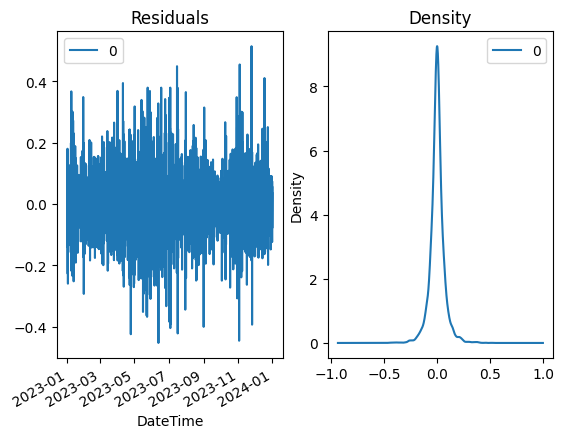

In [41]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt




# Choose the section of the dataframe that you want to model
#filtered_df = df["2023-6-01":"2023-12-01"]

# ARIMA Model parameters (p, d, q)
# These should be chosen based on your prior analysis, ACF, PACF, and stationarity tests
p = 1  # Replace with your chosen value
d =  0 # Replace with your chosen value, based on your earlier statement that no differencing is needed
q = 3  # Replace with your chosen value

# Fit the ARIMA model
model = ARIMA(df_filtered["systemPricelog"].diff().diff(24).dropna(), order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()




In [55]:

train_size = int(len(df_filtered["systemPricelog"]) * 0.8)
train, test = df_filtered["systemPricelog"][0:train_size], df_filtered["systemPricelog"][train_size:len(df_filtered["systemPricelog"])]


In [50]:
train

DateTime
2023-01-01 00:00:00    3.977342
2023-01-01 01:00:00    3.944291
2023-01-01 02:00:00    3.828776
2023-01-01 03:00:00    3.723957
2023-01-01 04:00:00    3.544928
                         ...   
2023-10-19 20:00:00    3.674661
2023-10-19 21:00:00    3.670333
2023-10-19 22:00:00    3.647918
2023-10-19 23:00:00    3.627382
2023-10-20 00:00:00    3.651614
Name: systemPricelog, Length: 7000, dtype: float64

## Working ARIMA, SUS

In [73]:
df = pd.read_excel("System_combined.xlsx")
df.set_index("DateTime", inplace=True)
df.sort_index(ascending=True)
df = df.drop("Unnamed: 0", axis = 1)
df['systemPrice'].interpolate(method='time', inplace=True)
df.isna().sum()

systemPrice    0
dtype: int64

Log transforming

In [65]:
df["systemPrice"] = df["systemPrice"] + 35
df["systemPrice"] = np.log(df["systemPrice"])


systemPrice    3.601017
dtype: float64

In [112]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
filtered_dfArima = df_filtered["systemPricelog"].diff(24).dropna()
window_size = 24  # Size of the moving window

# Make sure to have enough data for the initial window plus one new point to predict
assert len(filtered_dfArima) >= window_size + 1

# Start the training set just with the size of the window
#train, test = filtered_dfArima[:window_size], filtered_dfArima[window_size:]

order = (1, 1, 2)  # Example non-seasonal order
seasonal_order = (1, 0, 2, 24)  # Example seasonal order

history = train.tolist()  # Initialize history with the training set
predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    
    # Forecasted value in log scale
    yhat_log = output[0]
    
    # Convert from log scale back to original scale
    yhat_original = np.exp(yhat_log)
    predictions.append(yhat_original)
    
    # Append the observed log-transformed value to history for the next prediction
    history.append(test.iloc[t])  # No need to add 35 here, as it's already in log form
    history = history[-window_size:]  # Keep only the most recent observations
 # keep only the most recent observations

# Convert predictions to a Series
predictions_series = pd.Series(predictions, index=test.index)


#88min 22.3s all years
#47min 2022-2023

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

KeyboardInterrupt: 

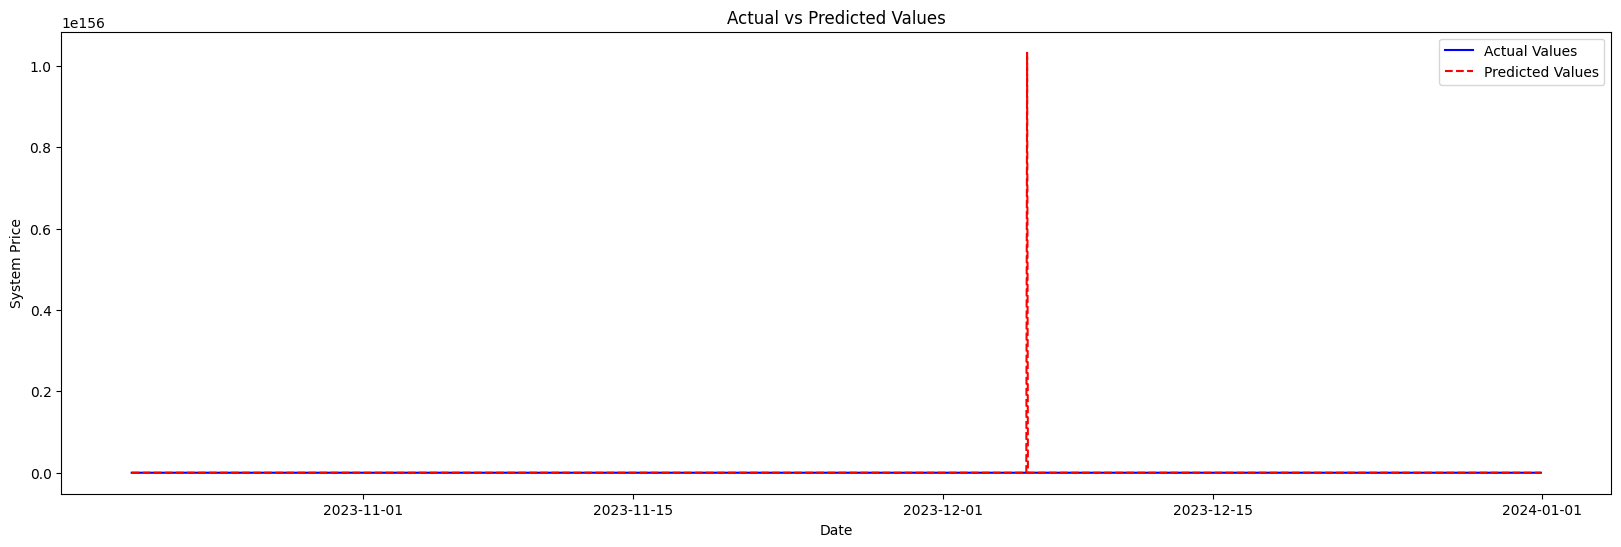

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Reverse the log transformation on the actual values
actual_values = np.exp(test)  # Assuming `test` is already in log scale
# Ensure that the index of actual values and predictions aligns for correct plotting
assert actual_values.index.equals(predictions_series.index)

# Plotting
plt.figure(figsize=(20, 6))  # Set the figure size for better readability
plt.plot(actual_values.index, actual_values, color='blue', label='Actual Values')  # Plot actual values in blue
plt.plot(predictions_series.index, predictions_series, color='red', linestyle='--', label='Predicted Values')  # Plot predicted values in red with dashed lines
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('System Price')
plt.legend()
plt.show()



In [102]:
test = np.exp(test)

## 24 Hour performance

RMSE for the first 24 hours: 1.0931452473986878e+23
MAE for the first 24 hours: 2.610606471471118e+22


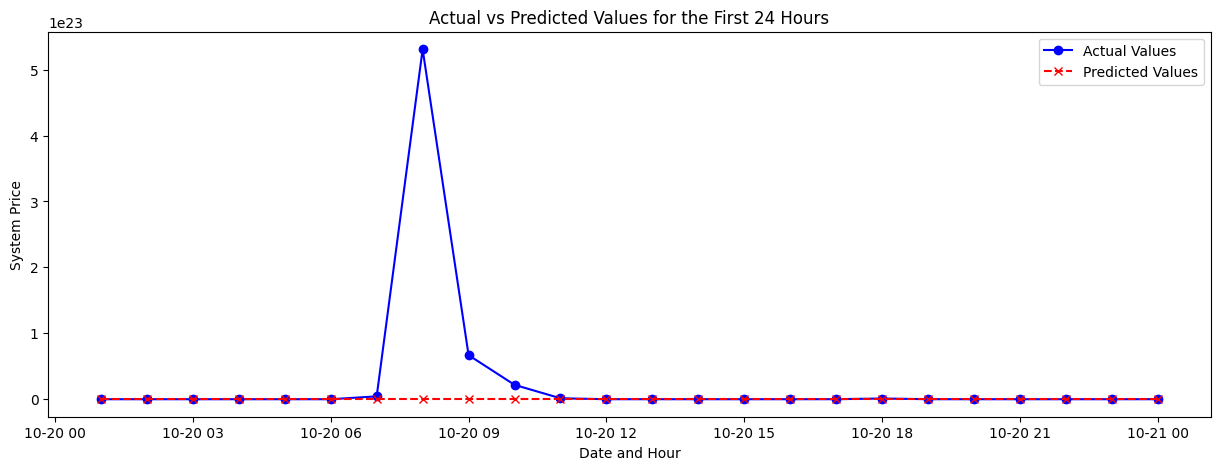

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute the RMSE and MAE for the first 24 hours
actual_first_24 = np.exp(test.iloc[:24])  # Assuming 'test' is the log of (price + 35)
predicted_first_24 = predictions_series.iloc[:24]

rmse = np.sqrt(mean_squared_error(actual_first_24, predicted_first_24))
mae = mean_absolute_error(actual_first_24, predicted_first_24)

# Print the performance metrics
print(f"RMSE for the first 24 hours: {rmse}")
print(f"MAE for the first 24 hours: {mae}")

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(actual_first_24.index, actual_first_24, marker='o', color='blue', label='Actual Values')
plt.plot(predicted_first_24.index, predicted_first_24, marker='x', linestyle='--', color='red', label='Predicted Values')
plt.title('Actual vs Predicted Values for the First 24 Hours')
plt.xlabel('Date and Hour')
plt.ylabel('System Price')
plt.legend()
plt.show()


## Accuracy Measure

In [86]:
import numpy as np

# Calculate RMSE
def calculate_rmse(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Calculate MAE
def calculate_mae(actual, predicted):
    mae = np.mean(np.abs(actual - predicted))
    return mae

# Assuming `actual_values` and `predictions_series` are already defined
rmse = calculate_rmse(actual_values, predictions_series)
mae = calculate_mae(actual_values, predictions_series)


print(f"RMSE: {rmse}")
print(f"MAE: {mae}")



RMSE: 25.954992633543018
MAE: 19.253697468191532


## Acorr Ljungbox test for stationarity

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming 'residuals' is a pandas Series of numerical data containing the residuals of your STL model
# Ensure that 'residuals' are indeed floats and not strings
#residuals = residuals.astype(float)

# Apply the Ljung-Box test
lb_results = acorr_ljungbox(df["systemPrice_STL"], lags=[24], return_df=True)

# Print the results
print(lb_results)

# Check the p-value for significance
if lb_results['lb_pvalue'].iloc[0] < 0.05:
    print("The residuals are not white noise, indicating correlation in the data.")
else:
    print("The residuals are white noise, indicating no correlation.")



The Ljung-Box test results indicate a very high test statistic and a p-value of 0.0 for the residuals of your STL-decomposed series. This suggests that there is strong evidence of autocorrelation in the residuals at the first 10 lags.

When the Ljung-Box test statistic is significant (as in your case, where the p-value is effectively 0), this implies that the residuals are not independently distributed, and hence, they are not white noise. This could mean that there is still some structure left in your time series data that the STL decomposition did not fully capture, or there could be other dynamics at play that have not been accounted for.

In [ ]:
plot_acf(df["systemPrice_STL"].dropna(), lags=24)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

plot_pacf(df["systemPrice_STL"].dropna(), lags=24)
plt.title('Autocorrelation Function (PACF) Plot')
plt.show()

